# Filtrando ruído com autoencoder convolutional

Nesta aplicação, o autocodificador é utilizado como filtro de ruído. 
Utiliza-se o dataset do MNIST, que é adicionado ruído gaussiano.
A rede é treinada com a entrada com a imagem ruidosa e a saída como a imagem original.

## Importação dos módulos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
#K.set_image_data_format("channels_first")
K.set_image_data_format("channels_last")

from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
import sys,os
sys.path.append("../src")
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

## Classe para apoio ao treinamento

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["mae"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Leitura do dataset - MNIST

In [72]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy  = np.clip(x_test_noisy, 0.,1.)

In [73]:
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


##  Mostrando 10 imagens

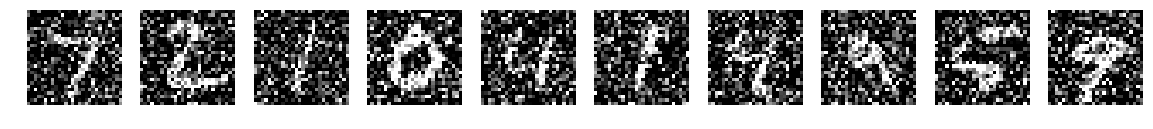

In [74]:
n = 10
plt.figure(figsize=(20, 2))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.axis('off')
plt.show()

## Rede autoencoder

In [75]:
input_img = Input(shape=(None, None, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_img,decoded)

## Sumário da rede

In [76]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, None, None, 32)    0         
__________

## Poucas amostras para teste inicial

In [77]:
testing = True
if testing:
    n_samples = 1000
    x_train = x_train[:n_samples]
    x_train_noisy = x_train_noisy[:n_samples]
    
    n_samples_test = 200
    x_test = x_test[:n_samples_test]
    x_test_noisy = x_test_noisy[:n_samples_test]
print(x_train.shape, x_train_noisy.shape)

(1000, 28, 28, 1) (1000, 28, 28, 1)


In [78]:
print(x_train[0].mean(),x_train_noisy[0].mean())

0.13768 0.296731933876


## Treinamento

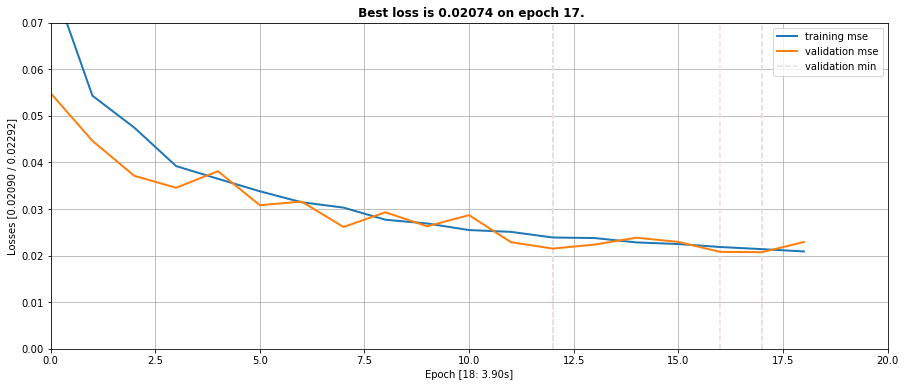

In [ ]:
model_name = '../../models/FiltrandoRuidoAutoencoder'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        RMSprop(),
    'batch_size': 32, 
    'nepochs':    20,
    'patience':   5,
    'ploss':      0.07,
    'reset':      False,
}

train_network(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, **fit_params);

## Testando 10 primeiras amostras de teste

In [80]:
y_hat = autoencoder.predict(x_test_noisy[:10],batch_size=10)
print(y_hat.shape)

(10, 28, 28, 1)


In [81]:
y_hat[0] /= y_hat[0].max()

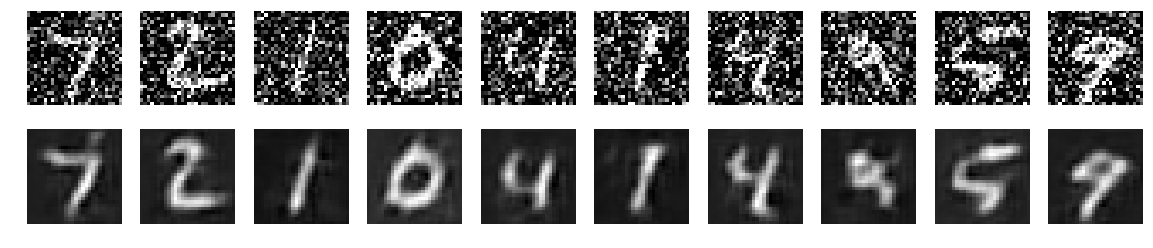

In [82]:
n = 10
fig = plt.figure(figsize=(20, 4))
plt.gray()
#fig,ax = plt.subplots(2,10)
for i in range(n):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(x_test_noisy[i].reshape(28, 28))
    ax.axis('off')
for i in range(n):
    ax = fig.add_subplot(2, 10, i+11)
    ax.imshow(y_hat[i].reshape(28, 28))
    ax.axis('off')
plt.show();

## Testando com imagem de tamanho maior

Como a rede é formada de camadas convolucionais, é possível que a imagem de entrada tenha qualquer tamanho.
Veja o exemplo a seguir, onde 4 imagens são juntadas para formar uma de shape=(56,56).

(1, 56, 56, 1)


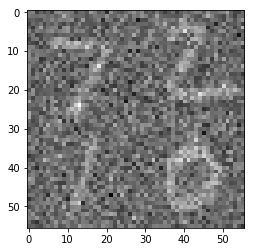

In [50]:
img1 = np.hstack([x_test_noisy[0],x_test_noisy[1]])
img2 = np.hstack([x_test_noisy[2],x_test_noisy[3]])
img = np.vstack([img1,img2]).reshape(1,56,56,1)
print(img.shape)
plt.imshow(img.reshape(56,56),cmap='gray')
                 

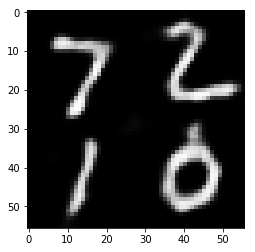

In [51]:
yy_hat = autoencoder.predict(img,batch_size=1)
plt.imshow(yy_hat.reshape(56,56),cmap='gray');

## Aprendizados